*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow

Sebastian Raschka 

CPython 3.6.1
IPython 6.0.0

tensorflow 1.2.0


# Model Zoo -- Convolutional General Adversarial Networks

Implementation of General Adversarial Nets (GAN) where both the discriminator and generator have convolutional and deconvolutional layers, respectively. In this example, the GAN generator was trained to generate MNIST images.

Uses

- samples from a random normal distribution (range [-1, 1])
- dropout
- leaky relus
- batch normalization
- separate batches for "fake" and "real" images (where the labels are 1 = real images, 0 = fake images)
- MNIST images normalized to [-1, 1] range
- generator with tanh output


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pickle as pkl

tf.test.gpu_device_name()

''

In [3]:
### Abbreviatiuons
# dis_*: discriminator network
# gen_*: generator network

########################
### Helper functions
########################

def leaky_relu(x, alpha=0.0001):
    return tf.maximum(alpha * x, x)



#########################
### SETTINGS
#########################

# Hyperparameters
learning_rate = 0.001
training_epochs = 50
batch_size = 64
dropout_rate = 0.5

# Architecture
dis_input_size = 784
gen_input_size = 100

# Other settings
print_interval = 200
random_seed = 123


########################
### DATASET
########################

np.random.seed(random_seed) # set seed for mnist shuffling
mnist = input_data.read_data_sets('MNIST_data')


#########################
### GRAPH DEFINITION
#########################

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(random_seed)
    
    # Placeholders for settings
    dropout = tf.placeholder(tf.float32, shape=None, name='dropout')
    is_training = tf.placeholder(tf.bool, shape=None, name='is_training')
    
    # Input data
    dis_x = tf.placeholder(tf.float32, shape=[None, dis_input_size],
                           name='discriminator_inputs')     
    gen_x = tf.placeholder(tf.float32, [None, gen_input_size],
                           name='generator_inputs')


    ##################
    # Generator Model
    ##################

    with tf.variable_scope('generator'):
        
        # 100 => 784 => 7x7x64
        gen_fc = tf.layers.dense(inputs=gen_x, units=3136,
                                 bias_initializer=None, # no bias required when using batch_norm
                                 activation=None)
        gen_fc = tf.layers.batch_normalization(gen_fc, training=is_training)
        gen_fc = leaky_relu(gen_fc)
        gen_fc = tf.reshape(gen_fc, (-1, 7, 7, 64))
        
        # 7x7x64 => 14x14x32
        deconv1 = tf.layers.conv2d_transpose(gen_fc, filters=32, 
                                             kernel_size=(3, 3), strides=(2, 2), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv1 = tf.layers.batch_normalization(deconv1, training=is_training)
        deconv1 = leaky_relu(deconv1)     
        deconv1 = tf.layers.dropout(deconv1, rate=dropout_rate)
        
        # 14x14x32 => 28x28x16
        deconv2 = tf.layers.conv2d_transpose(deconv1, filters=16, 
                                             kernel_size=(3, 3), strides=(2, 2), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_training)
        deconv2 = leaky_relu(deconv2)     
        deconv2 = tf.layers.dropout(deconv2, rate=dropout_rate)
        
        # 28x28x16 => 28x28x8
        deconv3 = tf.layers.conv2d_transpose(deconv2, filters=8, 
                                             kernel_size=(3, 3), strides=(1, 1), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_training)
        deconv3 = leaky_relu(deconv3)     
        deconv3 = tf.layers.dropout(deconv3, rate=dropout_rate)
        
        # 28x28x8 => 28x28x1
        gen_logits = tf.layers.conv2d_transpose(deconv3, filters=1, 
                                                kernel_size=(3, 3), strides=(1, 1), 
                                                padding='same',
                                                bias_initializer=None,
                                                activation=None)
        
        gen_out = tf.tanh(gen_logits, 'generator_outputs')


    ######################
    # Discriminator Model
    ######################
    
    def build_discriminator_graph(input_x, reuse=None):

        with tf.variable_scope('discriminator', reuse=reuse):
            
            # 28x28x1 => 14x14x8
            conv_input = tf.reshape(input_x, (-1, 28, 28, 1))
            conv1 = tf.layers.conv2d(conv_input, filters=8, kernel_size=(3, 3),
                                     strides=(2, 2), padding='same',
                                     bias_initializer=None,
                                     activation=None)
            conv1 = tf.layers.batch_normalization(conv1, training=is_training)
            conv1 = leaky_relu(conv1)
            conv1 = tf.layers.dropout(conv1, rate=dropout_rate)
            
            # 14x14x8 => 7x7x32
            conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=(3, 3),
                                     strides=(2, 2), padding='same',
                                     bias_initializer=None,
                                     activation=None)
            conv2 = tf.layers.batch_normalization(conv2, training=is_training)
            conv2 = leaky_relu(conv2)
            conv2 = tf.layers.dropout(conv2, rate=dropout_rate)

            # fully connected layer
            fc_input = tf.reshape(conv2, (-1, 7*7*32))
            logits = tf.layers.dense(inputs=fc_input, units=1, activation=None)
            out = tf.sigmoid(logits)
            
        return logits, out    

    # Create a discriminator for real data and a discriminator for fake data
    dis_real_logits, dis_real_out = build_discriminator_graph(dis_x, reuse=False)
    dis_fake_logits, dis_fake_out = build_discriminator_graph(gen_out, reuse=True)


    #####################################
    # Generator and Discriminator Losses
    #####################################
    
    # Two discriminator cost components: loss on real data + loss on fake data
    # Real data has class label 0, fake data has class label 1
    dis_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real_logits, 
                                                            labels=tf.zeros_like(dis_real_logits))
    dis_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, 
                                                            labels=tf.ones_like(dis_fake_logits))
    dis_cost = tf.add(tf.reduce_mean(dis_fake_loss), 
                      tf.reduce_mean(dis_real_loss), 
                      name='discriminator_cost')
 
    # Generator cost: difference between dis. prediction and label "0" for real images
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits,
                                                       labels=tf.zeros_like(dis_fake_logits))
    gen_cost = tf.reduce_mean(gen_loss, name='generator_cost')
    
    
    #########################################
    # Generator and Discriminator Optimizers
    #########################################
      
    dis_optimizer = tf.train.AdamOptimizer(learning_rate)
    dis_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
    dis_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    
    with tf.control_dependencies(dis_update_ops): # required to upd. batch_norm params
        dis_train = dis_optimizer.minimize(dis_cost, var_list=dis_train_vars,
                                           name='train_discriminator')
    
    gen_optimizer = tf.train.AdamOptimizer(learning_rate)
    gen_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
    gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    with tf.control_dependencies(gen_update_ops): # required to upd. batch_norm params
        gen_train = gen_optimizer.minimize(gen_cost, var_list=gen_train_vars,
                                           name='train_generator')
    
    # Saver to save session for reuse
    saver = tf.train.Saver()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
##########################
### TRAINING & EVALUATION
##########################

with tf.Session(graph=g) as sess:
    
    print('Initializing variables:')
    sess.run(tf.global_variables_initializer())
    print('\nGenerator:')
    for i in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='generator'):
        print(i)
    print('\nDiscriminator:')
    for i in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='discriminator'):
        print(i)
    
    avg_costs = {'discriminator': [], 'generator': []}

    for epoch in range(training_epochs):
        dis_avg_cost, gen_avg_cost = 0., 0.
        total_batch = mnist.train.num_examples // batch_size

        for i in range(total_batch):
            
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            batch_x = batch_x*2 - 1 # normalize
            batch_randsample = np.random.uniform(-1, 1, size=(batch_size, gen_input_size))
            
            # Train
            
            _, dc = sess.run(['train_discriminator', 'discriminator_cost:0'],
                             feed_dict={'discriminator_inputs:0': batch_x, 
                                        'generator_inputs:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            
            _, gc = sess.run(['train_generator', 'generator_cost:0'],
                             feed_dict={'generator_inputs:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            
            dis_avg_cost += dc
            gen_avg_cost += gc

            if not i % print_interval:
                print("Minibatch: %04d | Dis/Gen Cost:    %.3f/%.3f" % (i + 1, dc, gc))
            break
                

        print("Epoch:     %04d | Dis/Gen AvgCost: %.3f/%.3f" % 
              (epoch + 1, dis_avg_cost / total_batch, gen_avg_cost / total_batch))
        
        avg_costs['discriminator'].append(dis_avg_cost / total_batch)
        avg_costs['generator'].append(gen_avg_cost / total_batch)
        break
    
    saver.save(sess, save_path='./gan-conv.ckpt')

Initializing variables:

Generator:
<tf.Variable 'generator/dense/kernel:0' shape=(100, 3136) dtype=float32_ref>
<tf.Variable 'generator/dense/bias:0' shape=(3136,) dtype=float32_ref>
<tf.Variable 'generator/batch_normalization/beta:0' shape=(3136,) dtype=float32_ref>
<tf.Variable 'generator/batch_normalization/gamma:0' shape=(3136,) dtype=float32_ref>
<tf.Variable 'generator/batch_normalization/moving_mean:0' shape=(3136,) dtype=float32_ref>
<tf.Variable 'generator/batch_normalization/moving_variance:0' shape=(3136,) dtype=float32_ref>
<tf.Variable 'generator/conv2d_transpose/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>
<tf.Variable 'generator/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'generator/batch_normalization_1/beta:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'generator/batch_normalization_1/gamma:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'generator/batch_normalization_1/moving_mean:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'generator

Minibatch: 0001 | Dis/Gen Cost:    1.533/0.957
Epoch:     0001 | Dis/Gen AvgCost: 0.002/0.001


In [19]:
####################################
### RELOAD & GENERATE SAMPLE IMAGES
####################################


n_examples = 25

g = tf.Graph()
with tf.Session(graph=g) as sess:
    with g.as_default():
        
        tf.set_random_seed(random_seed)

        # Placeholders for settings
        dropout = tf.placeholder(tf.float32, shape=None, name='dropout')
        is_training = tf.placeholder(tf.bool, shape=None, name='is_training')

        # Input data
        dis_x = tf.placeholder(tf.float32, shape=[None, dis_input_size],
                               name='discriminator_inputs')     
        gen_x = tf.placeholder(tf.float32, [None, gen_input_size],
                               name='generator_inputs')


        ##################
        # Generator Model
        ##################

        with tf.variable_scope('generator'):

            # 100 => 784 => 7x7x64
            gen_fc = tf.layers.dense(inputs=gen_x, units=3136,
                                     bias_initializer=None, # no bias required when using batch_norm
                                     activation=None)
            gen_fc = tf.layers.batch_normalization(gen_fc, training=is_training)
            gen_fc = leaky_relu(gen_fc)
            gen_fc = tf.reshape(gen_fc, (-1, 7, 7, 64))

            # 7x7x64 => 14x14x32
            deconv1 = tf.layers.conv2d_transpose(gen_fc, filters=32, 
                                                 kernel_size=(3, 3), strides=(2, 2), 
                                                 padding='same',
                                                 bias_initializer=None,
                                                 activation=None)
            deconv1 = tf.layers.batch_normalization(deconv1, training=is_training)
            deconv1 = leaky_relu(deconv1)     
            deconv1 = tf.layers.dropout(deconv1, rate=dropout_rate)

            # 14x14x32 => 28x28x16
            deconv2 = tf.layers.conv2d_transpose(deconv1, filters=16, 
                                                 kernel_size=(3, 3), strides=(2, 2), 
                                                 padding='same',
                                                 bias_initializer=None,
                                                 activation=None)
            deconv2 = tf.layers.batch_normalization(deconv2, training=is_training)
            deconv2 = leaky_relu(deconv2)     
            deconv2 = tf.layers.dropout(deconv2, rate=dropout_rate)

            # 28x28x16 => 28x28x8
            deconv3 = tf.layers.conv2d_transpose(deconv2, filters=8, 
                                                 kernel_size=(3, 3), strides=(1, 1), 
                                                 padding='same',
                                                 bias_initializer=None,
                                                 activation=None)
            deconv3 = tf.layers.batch_normalization(deconv3, training=is_training)
            deconv3 = leaky_relu(deconv3)     
            deconv3 = tf.layers.dropout(deconv3, rate=dropout_rate)

            # 28x28x8 => 28x28x1
            gen_logits = tf.layers.conv2d_transpose(deconv3, filters=1, 
                                                    kernel_size=(3, 3), strides=(1, 1), 
                                                    padding='same',
                                                    bias_initializer=None,
                                                    activation=None)

            gen_out = tf.tanh(gen_logits, 'generator_outputs')


        ######################
        # Encoder Model
        ######################

        def build_encoder_graph(input_x, reuse=None):

            with tf.variable_scope('discriminator', reuse=reuse):

                # 28x28x1 => 14x14x8
                conv_input = tf.reshape(input_x, (-1, 28, 28, 1))
                conv1 = tf.layers.conv2d(conv_input, filters=8, kernel_size=(3, 3),
                                         strides=(2, 2), padding='same',
                                         bias_initializer=None,
                                         activation=None)
                conv1 = tf.layers.batch_normalization(conv1, training=is_training)
                conv1 = leaky_relu(conv1)
                conv1 = tf.layers.dropout(conv1, rate=dropout_rate)

                # 14x14x8 => 7x7x32
                conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=(3, 3),
                                         strides=(2, 2), padding='same',
                                         bias_initializer=None,
                                         activation=None)
                conv2 = tf.layers.batch_normalization(conv2, training=is_training)
                conv2 = leaky_relu(conv2)
                conv2 = tf.layers.dropout(conv2, rate=dropout_rate)

                # fully connected layer
                fc_input = tf.reshape(conv2, (-1, 7*7*32))
                logits = tf.layers.dense(inputs=fc_input, units=gen_input_size, activation=None)
                out = tf.sigmoid(logits)

            return logits, out    

        enc_real_logits, enc_real_out = build_encoder_graph(dis_x, reuse=None)

        
        saver = tf.train.Saver()
        
        
        
##############    
        
    saver.restore(sess, save_path='./gan-conv.ckpt')



INFO:tensorflow:Restoring parameters from ./gan-conv.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [100] rhs shape= [1]
	 [[Node: save/Assign_12 = Assign[T=DT_FLOAT, _class=["loc:@discriminator/dense/bias"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](discriminator/dense/bias, save/RestoreV2_12)]]

Caused by op 'save/Assign_12', defined at:
  File "/Users/sebastian/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sebastian/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-6318202408c7>", line 116, in <module>
    saver = tf.train.Saver()
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 271, in assign
    validate_shape=validate_shape)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 45, in assign
    use_locking=use_locking, name=name)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/sebastian/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [100] rhs shape= [1]
	 [[Node: save/Assign_12 = Assign[T=DT_FLOAT, _class=["loc:@discriminator/dense/bias"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](discriminator/dense/bias, save/RestoreV2_12)]]


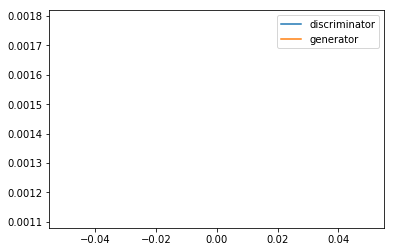

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(avg_costs['discriminator'])), 
         avg_costs['discriminator'], label='discriminator')
plt.plot(range(len(avg_costs['generator'])),
         avg_costs['generator'], label='generator')
plt.legend()
plt.show()

INFO:tensorflow:Restoring parameters from ./gan-conv.ckpt


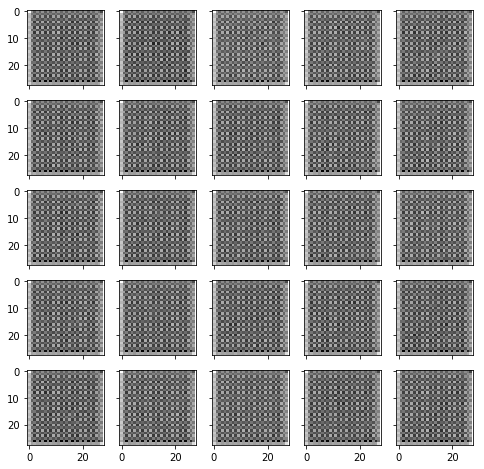

In [9]:
####################################
### RELOAD & GENERATE SAMPLE IMAGES
####################################


n_examples = 25

with tf.Session(graph=g) as sess:
    saver.restore(sess, save_path='./gan-conv.ckpt')

    batch_randsample = np.random.uniform(-1, 1, size=(n_examples, gen_input_size))
    new_examples = sess.run('generator/generator_outputs:0',
                            feed_dict={'generator_inputs:0': batch_randsample,
                                       'dropout:0': 0.0,
                                       'is_training:0': False})

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                         sharey=True, sharex=True)

for image, ax in zip(new_examples, axes.flatten()):
    ax.imshow(image.reshape((dis_input_size // 28, dis_input_size // 28)), cmap='binary')

plt.show()